In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Use seaborn style defaults and set the default figure size and dpi
sns.set_theme(rc={'figure.figsize':(8, 6), 'figure.dpi':300})
sns.set_style("whitegrid")

In [3]:
def euler_method(f, y0, dt, T):
    # Initialize time and solution arrays
    times = [i*dt for i in range(int(T/dt) + 1)]
    y = [y0]

    # Iterate over each time step
    for t in times[:-1]:
        # Compute the derivative
        dy = f(y[-1], t)
        
        # Update the solution using the Euler method
        y.append(y[-1] + dt*dy)

    sol = {'times': times, 'y': y}
    return sol

$$
\dot{y} = -15y \quad y(0) = 1
$$

with the exact solution:

$$
y(t) = e^{-15t}
$$

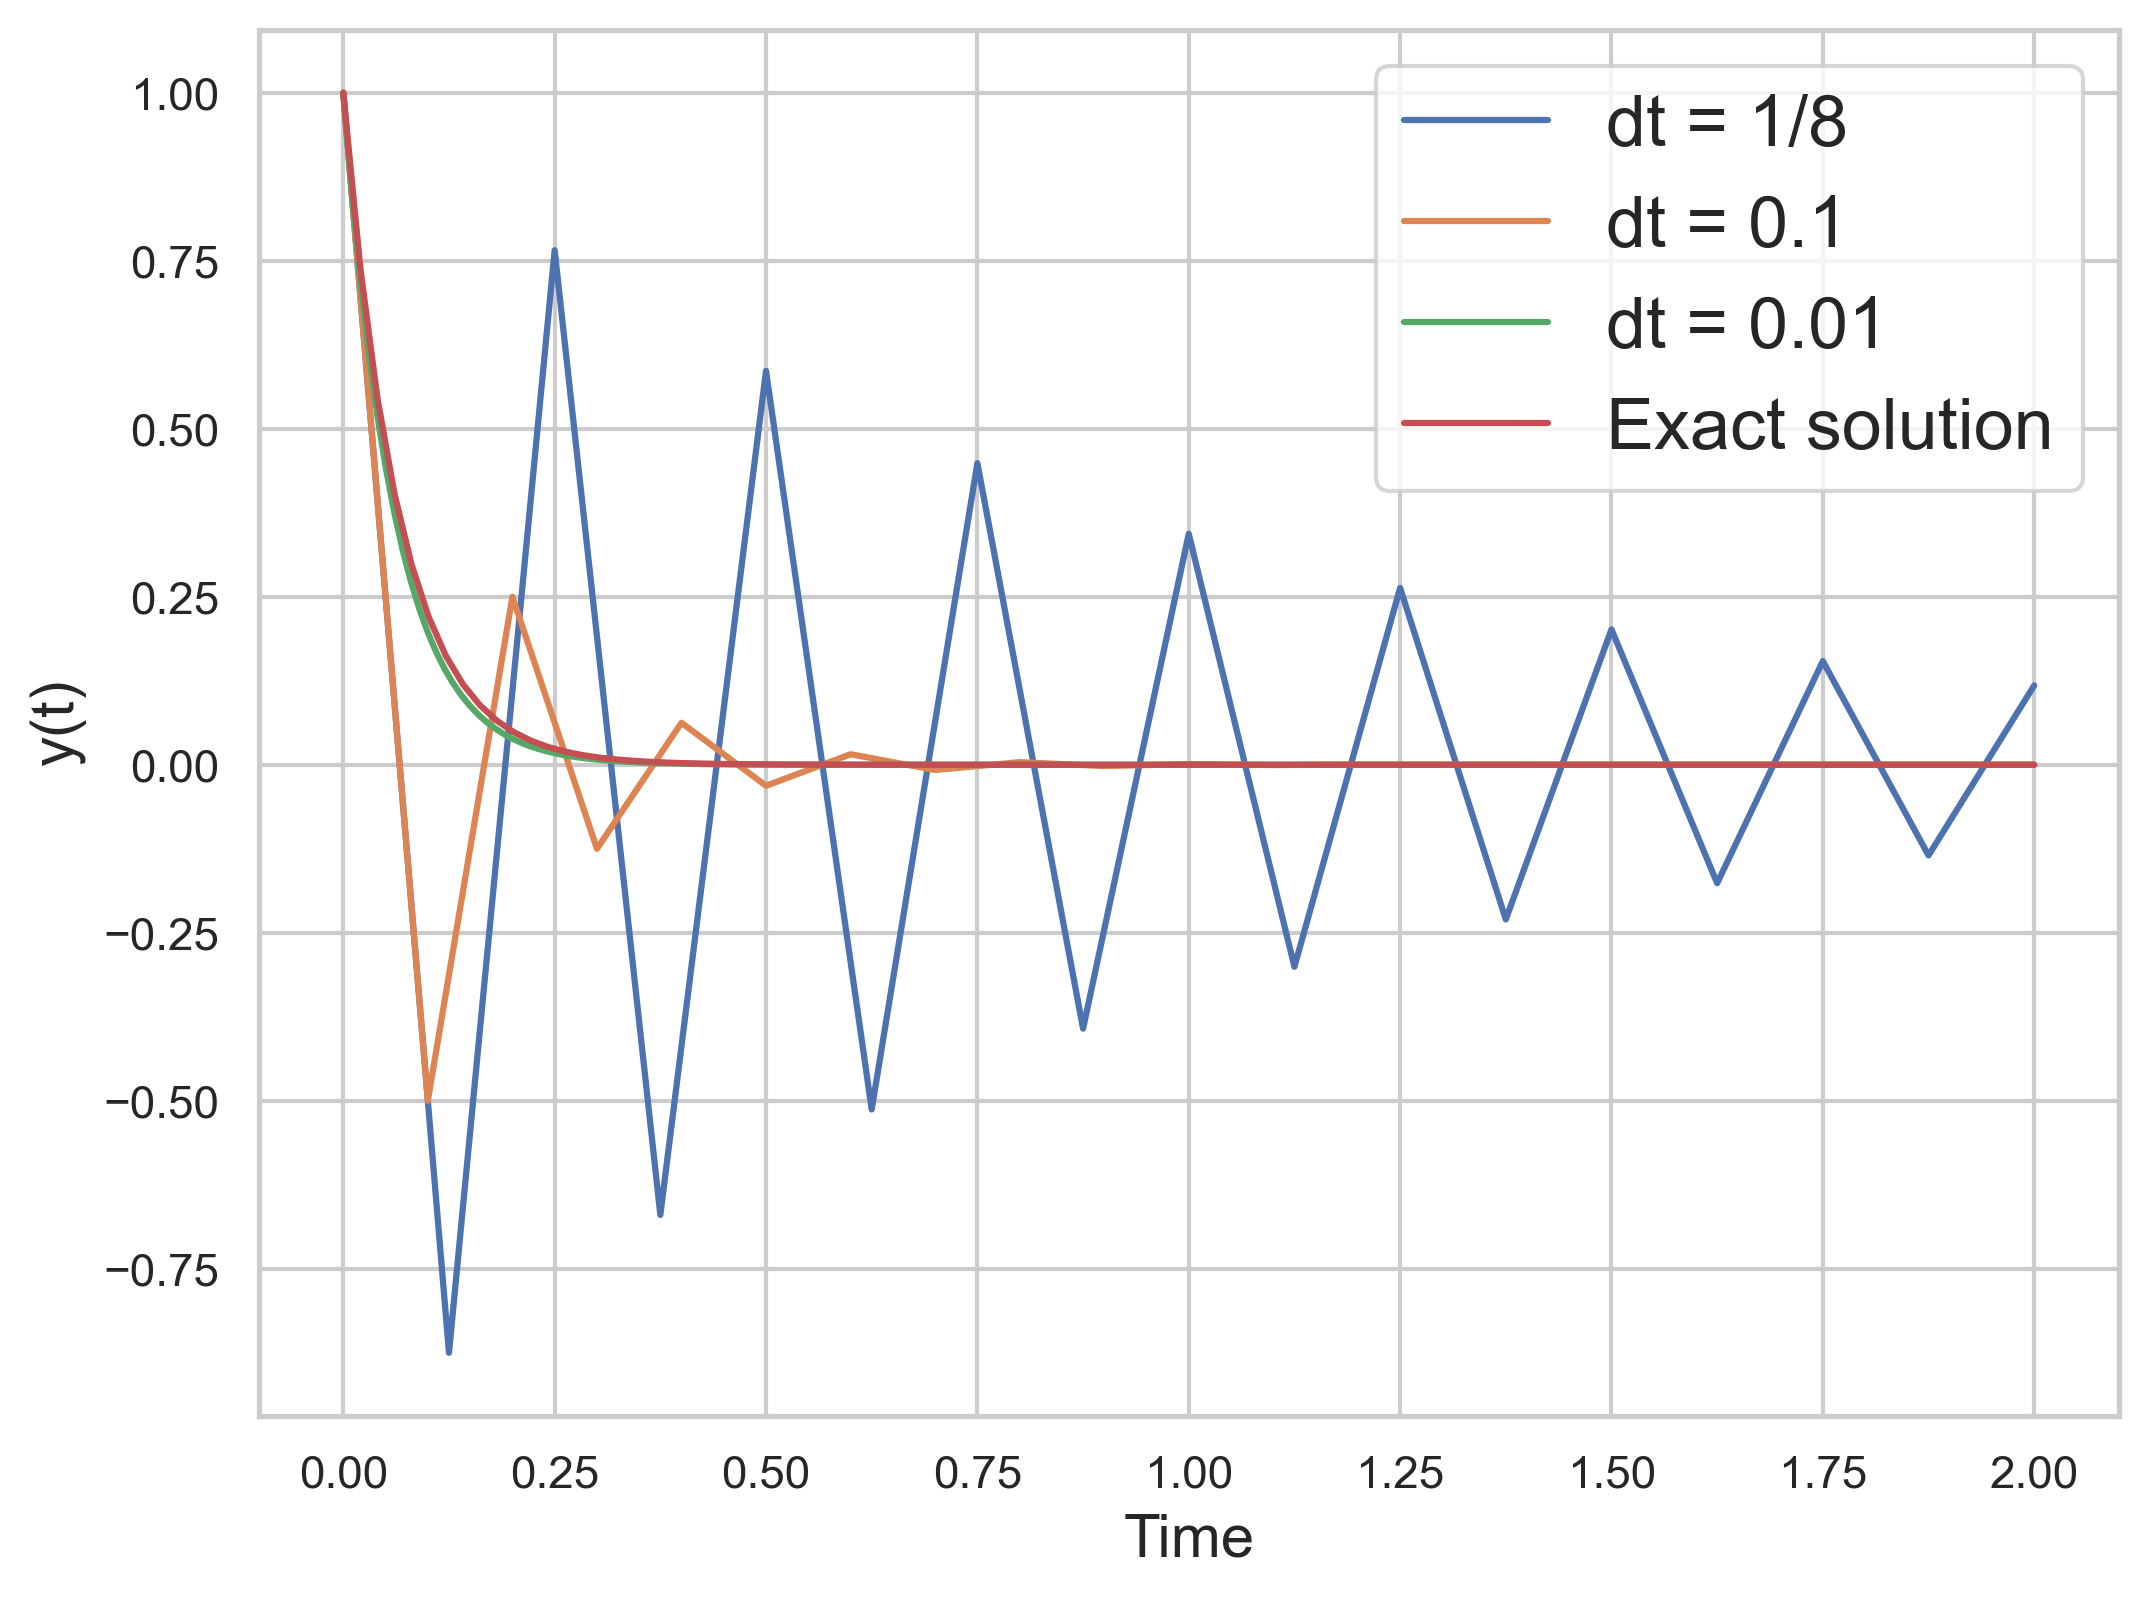

In [15]:
# Euler method
def f(y, t):
    return -15*y

y0 = 1
dt = 0.1
T = 2

# Plot the solution
plt.plot(euler_method(f, y0, 1/8, T)['times'], euler_method(f, y0, 1/8, T)['y'], label='dt = 1/8')
plt.plot(euler_method(f, y0, 0.1, T)['times'], euler_method(f, y0, 0.1, T)['y'], label='dt = 0.1')
plt.plot(euler_method(f, y0, 0.01, T)['times'], euler_method(f, y0, 0.01, T)['y'], label='dt = 0.01')
# odeint solution
# sol = odeint(f, y0, np.linspace(0, T, 100))
# times = np.linspace(0, T, 100)
# plt.plot(times, sol, label='odeint solution')
# Exact solution
t = np.linspace(0, T, 100)
plt.plot(t, np.exp(-15*t), label='Exact solution')
plt.xlabel('Time', fontsize='large')
plt.ylabel('y(t)', fontsize='large')
plt.legend(fontsize='x-large')
plt.savefig('asset/euler_method.png')
plt.show()

In [20]:
# Test time used
import time
start = time.time()
for i in range(100000):
    euler_method(f, y0, 0.01, T) # Test 1000 times
end = time.time()
print('Time used for dt = 0.01:', end - start)

start = time.time()
for i in range(100000):
    euler_method(f, y0, 0.1, T) # Test 1000 times
end = time.time()
print('Time used for dt = 0.1:', end - start)

start = time.time()
for i in range(100000):
    euler_method(f, y0, 1/8, T) # Test 1000 times
end = time.time()
print('Time used for dt = 1/8:', end - start)


Time used for dt = 0.01: 3.7898566722869873
Time used for dt = 0.1: 0.4230952262878418
Time used for dt = 1/8: 0.35508084297180176


Let us try simulating planar gravitational motion governed by the force law:

$$
\vec{F} = -\frac{m_{1}m_{2}}{r^2}\hat{r}
$$

where we use units such that gravitational constant is equal to unity.

Consider three bodies. The equations of motion for any body are given by:

$$
\ddot{\mathbf{r}}_{i} = -\sum_{i \neq j} \frac{m_{j}}{|\mathbf{r}_{i} - \mathbf{r}_{j}|^3}(\mathbf{r}_{i} - \mathbf{r}_{j})
$$

In [4]:
def update_state(input, dt, ignore=None):
    pos_1 = input[0]
    pos_2 = input[1]
    pos_3 = input[2]
    vel_1 = input[3]
    vel_2 = input[4]
    vel_3 = input[5]
    
    force = gravity(pos_1, pos_2, pos_3)
    
    unit_12 = (pos_1 - pos_2)/np.linalg.norm(pos_1 - pos_2) # from 2 to 1
    unit_13 = (pos_1 - pos_3)/np.linalg.norm(pos_1 - pos_3) # from 3 to 1
    unit_23 = (pos_2 - pos_3)/np.linalg.norm(pos_2 - pos_3) # from 3 to 2
    
    if ignore != 1:
        pos_1_new = pos_1 + vel_1*dt
        vel_1_new = vel_1 + (force[0]*(-unit_12) + force[1]*(-unit_13))*dt/m_1
    else:
        pos_1_new = pos_1
        vel_1_new = vel_1
    if ignore != 2:
        pos_2_new = pos_2 + vel_2*dt
        vel_2_new = vel_2 + (force[0]*unit_12 + force[2]*(-unit_23))*dt/m_2
    else:
        pos_2_new = pos_2
        vel_2_new = vel_2
    if ignore != 3:
        pos_3_new = pos_3 + vel_3*dt
        vel_3_new = vel_3 + (force[1]*unit_13 + force[2]*unit_23)*dt/m_3
    else:
        pos_3_new = pos_3
        vel_3_new = vel_3
    
    return [pos_1_new, pos_2_new, pos_3_new, vel_1_new, vel_2_new, vel_3_new]

def gravity(pos_1, pos_2, pos_3):
    r_12 = np.sqrt((pos_1[0] - pos_2[0])**2 + (pos_1[1] - pos_2[1])**2)
    r_13 = np.sqrt((pos_1[0] - pos_3[0])**2 + (pos_1[1] - pos_3[1])**2)
    r_23 = np.sqrt((pos_2[0] - pos_3[0])**2 + (pos_2[1] - pos_3[1])**2)
    f_12 = G*m_1*m_2/r_12**2
    f_13 = G*m_1*m_3/r_13**2
    f_23 = G*m_2*m_3/r_23**2
    return f_12, f_13, f_23

In [5]:
m_1 = 2e30 # approx mass of the sun
m_2 = 6e24 # approx mass of the earth
m_3 = 1e5 # approx mass of a spaceship
v_earth = 30e3 # approx velocity of the earth
r_earth = 1.5e11 # approx distance from the sun to the earth
G = 1

In [6]:
# Initial conditions
pos_1 = np.array([0, 0])
pos_2 = np.array([r_earth, 0])
pos_3 = np.array([1e15, 0])

vel_1 = np.array([0, 0])
vel_2 = np.array([0, v_earth])
vel_3 = np.array([0, 0])

init = np.array([pos_1, pos_2, pos_3, vel_1, vel_2, vel_3])

# Time parameters
T = 1e10
iterations = 100000
dt = T/iterations

# Simulate the system
t = 0
states = [init]
while t < T:
    new_state = update_state(states[-1], dt, ignore=1)
    states.append(new_state)
    t += dt
    
states = np.array(states)

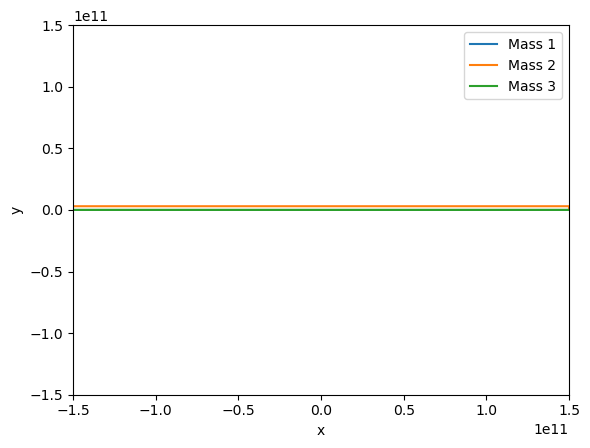

In [7]:
# Plot the solution
plt.plot(states[:, 0, 0], states[:, 0, 1], label='Mass 1')
plt.plot(states[:, 1, 0], states[:, 1, 1], label='Mass 2')
plt.plot(states[:, 2, 0], states[:, 2, 1], label='Mass 3')

# Set limits
plt.xlim(-1.5e11, 1.5e11)
plt.ylim(-1.5e11, 1.5e11)

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()